In [1]:
import os
import glob
import cv2
from pathlib import Path
import numpy as np
from torch.nn.functional import threshold


In [ ]:
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue == 0] = 0

    return labeled_img

In [ ]:
for img in predictions_masks_img:
    filename = Path(img).stem
    img = cv2.imread(img, 0)
    img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
    num_labels, labels_im = cv2.connectedComponents(img)

    print(num_labels)

    #labeled_img = imshow_components(labels_im)

In [ ]:
predictions_masks_path = "test_dataset/predictions/sor"
os.makedirs("test_dataset/labeled_masks", exist_ok=True)

predictions_masks_img = sorted(glob.glob(predictions_masks_path + "/*.png"))

In [ ]:
from PIL import Image

In [ ]:
import numpy as np
#for img in predictions_masks_img:
img = predictions_masks_img[0]
filename = Path(img).stem
img = cv2.imread(img, 0)
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
cv2.imshow(img)
num_labels, labels_im = cv2.connectedComponents(img)
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
cv2.imshow(img)
num_labels, labels_im = cv2.connectedComponents(img)
print(np.unique(labels_im))
print(num_labels)
labeled_img = Image.fromarray(labels_im)


In [2]:
import cv2

In [61]:
masks_path = "test_dataset/labeled_masks"
masks_img = sorted(glob.glob(masks_path + "/*.png"))
imkey = 0
mask= cv2.imread(masks_img[imkey], 0)

In [62]:
np.unique(mask)

array([  0,  31,  56,  73,  80,  82,  84,  94, 104, 123, 130, 150, 160,
       169, 172, 173, 180, 197, 223], dtype=uint8)

In [73]:
def compute_iou_binary(pred_bin: np.ndarray, gt_bin: np.ndarray, eps: float = 1e-7) -> float:
    inter = np.logical_and(pred_bin == 1, gt_bin == 1).sum(dtype=np.float64)
    union = np.logical_or (pred_bin == 1, gt_bin == 1).sum(dtype=np.float64)
    return float((inter + eps) / (union + eps))

Prédiction devrait etre binaire : [0 1]
La prédiction contient tous les labels : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Le mask contient tous les labels : [  0  31  51  63  72  80  87  92  95 102 103 135 143 154 155 163 170 175
 177 192 210 213]
Nombre d'objets dans la prédiction : 18
Nombre d'objets dans le mask ground truth : 21


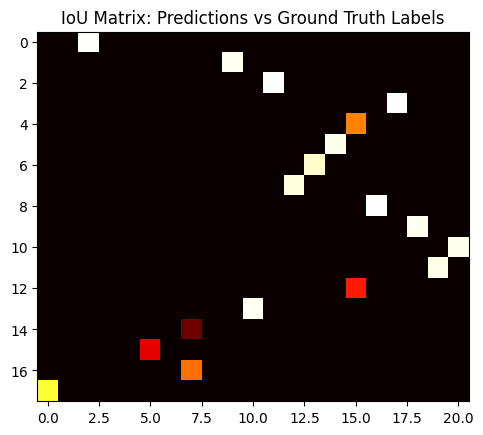

0.8648648648648649

In [78]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

predictions_masks_path = "test_dataset/labeled_masks"
masks_path = "test_dataset/labeled_train_masks"

predictions_masks_img = sorted(glob.glob(predictions_masks_path + "/*.png"))
masks_img = sorted(glob.glob(masks_path + "/*.png"))


imkey = 0

predicted = cv2.imread(predictions_masks_img[imkey], 0)
mask= cv2.imread(masks_img[imkey], 0)

## PREDICTION MASK BINAIRE VERS LABELS ###

predicted = (predicted > 0).astype(np.uint8)  # on peut binariser simplement les mask avec l'assertion >0 . Toutes les zones non nulles (donc les detections) deviennent 1
print("Prédiction devrait etre binaire :", np.unique(predicted))
num_labels_predicted, labels_im_predicted = cv2.connectedComponents(predicted)
print("La prédiction contient tous les labels :", np.unique(labels_im_predicted))



### GROUND TRUTH MASK LABELS ###
# Si le mask ground truth est chargé depuis le tif d'origine, il est déjà étiqueté (labels différents pour chaque objet). pas besoin de faire des connected components dessus.

assert len(np.unique(mask))>2, "Le mask ground truth doit contenir des labels différents pour chaque objet (pas binaire). Il devrait etre chargé directement depuis le tif." # verifier que le mask ground truth est bien a, sin
print("Le mask contient tous les labels :", np.unique(mask))



### CALCUL DE LA MATRICE D'IOU ENTRE LES OBJETS PRÉDITS ET LES OBJETS DU GROUND TRUTH ###

nb_predictions= len(np.unique(labels_im_predicted))-1  # on soustrait 1 pour ne pas compter le label 0 (background )
nb_ground_truth= len(np.unique(mask))-1  # on soustrait 1 pour ne pas compter le label 0 (background )
print("Nombre d'objets dans la prédiction :", nb_predictions)
print("Nombre d'objets dans le mask ground truth :", nb_ground_truth)

iou_matrix = np.zeros((nb_predictions, nb_ground_truth))

fp = 0
threshold = 0.1

# iou_matrix = compute_iou_binary(labels_im_predicted, mask)
labels_im_predicted_unique = np.unique(labels_im_predicted)
mask_unique = np.unique(mask)
for i in range(0, nb_predictions):
    for j in range(0, nb_ground_truth):
        intersection = np.logical_and(labels_im_predicted == labels_im_predicted_unique[i+1], mask == mask_unique[j+1]).sum()
        union = np.logical_or(labels_im_predicted == labels_im_predicted_unique[i+1], mask == mask_unique[j+1]).sum()
        iou_matrix[i, j] = intersection / union

# plot the iou matrix
plt.imshow(iou_matrix, cmap='hot', interpolation='nearest')
plt.title("IoU Matrix: Predictions vs Ground Truth Labels")
plt.show()


###CALCUL DES TP,FP, et FN ###
fp, fn = 0, 0
for i in range(0, nb_predictions): # pour chaque prediction
    if np.max(iou_matrix[i, :]) <= threshold:  # si la prediction n'a pas d'iou > threshold avec un objet du ground truth
        fp += 1  # c'est un faux positif

for i in range(0, nb_ground_truth): # pour chaque objet du ground truth
    if np.max(iou_matrix[:, i]) <= threshold:  # si un objet du ground truth n'a pas d'iou > threshold avec une prediction
        fn += 1  # c'est un faux negatif






matrix_copy = iou_matrix.copy().astype(float)
tp = 0

while True:
    # chercher le plus grand IoU restant
    best_val = -1.0
    best_i = -1
    best_j = -1
    for i in range(matrix_copy.shape[0]):          # lignes = prédictions
        for j in range(matrix_copy.shape[1]):      # colonnes = ground truth
            if matrix_copy[i, j] > best_val:
                best_val = matrix_copy[i, j]
                best_i = i
                best_j = j

    # si le meilleur ne dépasse pas le threshold, on arrête
    if best_val <= threshold:
        break

    # on valide ce couple comme un vrai positif
    tp += 1

    # on  la ligne et la colonne pour éviter toute réutilisation
    for jj in range(matrix_copy.shape[1]):
        matrix_copy[best_i, jj] = -1.0
    for ii in range(matrix_copy.shape[0]):
        matrix_copy[ii, best_j] = -1.0


# print(fp, fn)
# nb_preds_matched= nb_predictions - fp
# print("Nombre d'objets appariés dans la prédiction :", nb_preds_matched)
# nb_gt_matched= nb_ground_truth - fn
# print("Nombre d'objets appariés dans le ground truth :", nb_gt_matched)
#
# assert nb_preds_matched == nb_gt_matched, "Le nombre d'objets appariés entre la prédiction et le ground truth devrait être le même"
# normalement il ne reste que les vrais positifs
# tp = nb_preds_matched

f1score = (2*tp)/(2*tp+fp+fn)

f1score

In [81]:
tp, fp, fn


(16, 0, 5)